<a href="https://colab.research.google.com/github/juancuevas-ops/Desregulaci-n-de-la-Producci-n-de-Interleucina-12/blob/main/AN%C3%81LISIS_MOLECULAR_PROTEINA_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Bio
import os
import sys
from collections import Counter
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# ==============================================================================
# --- CONFIGURACIÓN DEL USUARIO ---
# ==============================================================================
# !! Modifica esta ruta !!
protein_faa_file_path = "/content/proteina_S.faa" # <-- ¡PON AQUÍ LA RUTA A TU ARCHIVO FAA!

# Aminoácidos estándar a considerar
STANDARD_AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"

# ==============================================================================
# --- FUNCIÓN PRINCIPAL DE ANÁLISIS DE COMPOSICIÓN ---
# ==============================================================================

def analyze_protein_composition(faa_file):
    """
    Analiza las secuencias de proteínas en un archivo FAA (FASTA Amino Acid)
    y calcula el porcentaje de cada aminoácido estándar.

    Args:
        faa_file (str): Ruta al archivo FAA.

    Returns:
        dict: {protein_id: {'length': int, 'aa_percentage': {aa: float}}}
              Retorna None si el archivo no se encuentra o hay un error.
    """
    if not os.path.exists(faa_file):
        print(f"Error: Archivo FAA '{faa_file}' no encontrado.", file=sys.stderr)
        return None

    results = {}
    processed_proteins = 0
    print(f"Info: Procesando archivo de proteínas: {faa_file}")

    try:
        for record in SeqIO.parse(faa_file, "fasta"):
            processed_proteins += 1
            protein_id = record.id
            # Obtener secuencia como string y limpiar (eliminar '*' de parada si existe)
            sequence = str(record.seq).upper().rstrip('*')
            seq_len = len(sequence)

            if seq_len == 0:
                print(f"Warning: Secuencia '{protein_id}' está vacía. Saltando.", file=sys.stderr)
                results[protein_id] = {'length': 0, 'aa_percentage': {aa: 0.0 for aa in STANDARD_AMINO_ACIDS}}
                continue

            # Calcular porcentajes usando ProteinAnalysis (maneja errores por AAs no estándar)
            # Nota: ProteinAnalysis ignora AAs no estándar (X, B, Z, etc.) en el conteo total.
            # Podríamos querer contarlos o excluirlos explícitamente si son comunes.
            try:
                analysed_seq = ProteinAnalysis(sequence)
                aa_percentages = analysed_seq.get_amino_acids_percent() # Devuelve dict {AA: percentage*100}
                # Formatear a porcentaje (dividir por 100 implícito en get_amino_acids_percent)
                # Asegurarse de que todos los AAs estándar están presentes, incluso si % es 0
                formatted_percentages = {aa: aa_percentages.get(aa, 0.0) * 100.0 for aa in STANDARD_AMINO_ACIDS}


            except ValueError as e:
                 # Manejar posible error si la secuencia contiene caracteres inválidos no manejados por ProteinAnalysis
                 print(f"Warning: Error analizando secuencia '{protein_id}'. Calculando manualmente. Error: {e}", file=sys.stderr)
                 # Cálculo manual como fallback (ignora AAs no estándar)
                 aa_counts = Counter(c for c in sequence if c in STANDARD_AMINO_ACIDS)
                 valid_len = sum(aa_counts.values())
                 if valid_len > 0:
                      formatted_percentages = {aa: (aa_counts.get(aa, 0) / valid_len) * 100.0 for aa in STANDARD_AMINO_ACIDS}
                 else:
                      formatted_percentages = {aa: 0.0 for aa in STANDARD_AMINO_ACIDS}


            results[protein_id] = {
                'length': seq_len,
                'aa_percentage': formatted_percentages
            }

        print(f"Info: Análisis de composición completado para {processed_proteins} proteína(s).")
        return results

    except Exception as e:
        print(f"Ocurrió un error inesperado durante el procesamiento del archivo FAA: {e}", file=sys.stderr)
        # import traceback; traceback.print_exc() # Para debug
        return None

# ==============================================================================
# --- EJECUCIÓN PRINCIPAL Y SALIDA ---
# ==============================================================================

if __name__ == "__main__":
    # Usar parámetros definidos en la sección de CONFIGURACIÓN
    protein_input_file = protein_faa_file_path

    # Ejecutar el análisis
    composition_results = analyze_protein_composition(protein_input_file)

    # Imprimir resultados
    if composition_results:
        print(f"\n===== COMPOSICIÓN DE AMINOÁCIDOS PARA: {protein_input_file} =====")
        print("\nNOTA: No hay 'valores de referencia' universales. La composición varía por proteína.")
        print("      Interpreta estos porcentajes en el contexto de cada proteína específica.\n")

        for protein_id, data in composition_results.items():
            print(f"--- Proteína: {protein_id} (Longitud: {data['length']} aa) ---")
            percentages = data['aa_percentage']
            # Imprimir porcentajes ordenados alfabéticamente
            sorted_aas = sorted(percentages.keys())
            output_lines = []
            for i in range(0, len(sorted_aas), 5): # Imprimir en grupos de 5 para legibilidad
                line = []
                for aa in sorted_aas[i:i+5]:
                    line.append(f"{aa}: {percentages[aa]:.2f}%")
                output_lines.append("   ".join(line))
            print("\n".join(output_lines))
            print("-" * 70)

    else:
        print("\nNo se generaron resultados. Verifica la ruta del archivo FAA y posibles errores.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.5 MB/s eta 0:00:00
Info: Procesando archivo de proteínas: /content/proteina_S.faa
Info: Análisis de composición completado para 1 proteína(s).

===== COMPOSICIÓN DE AMINOÁCIDOS PARA: /content/proteina_S.faa =====

NOTA: No hay 'valores de referencia' universales. La composición varía por proteína.
      Interpreta estos porcentajes en el contexto de cada proteína específica.

--- Proteína: YP_009724390.1 (Longitud: 1273 aa) ---
A: 6.21%   C: 3.14%   D: 4.87%   E: 3.77%   F: 6.05%
G: 6.44%   H: 1.34%   I: 5.97%   K: 4.79%   L: 8.48%
M: 1.10%   N: 6.91%   P: 4.56%   Q: 4.87%   R: 3.30%
S: 7.78%   T: 7.62%   V: 7.62%   W: 0.94%   Y: 4.24%
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


# Aminoácidos Alterados y sus Consecuencias Específicas
Cisteína (C)
Alto (3.14% vs. 1.5–2%)
Formación excesiva de puentes disulfuro → mayor estabilidad estructural.
Facilita la unión persistente al receptor ACE2, desencadenando inflamación crónica y daño endotelial.
Asparagina (N)
Alto (6.91% vs. 4–5%)
Aumento de glicosilación N-ligada → máscara inmunológica.
Evasión de anticuerpos y respuesta inmune adaptativa, prolongando la infección y la liberación de citoquinas proinflamatorias (ej. IL-6, TNF-α).
Tirosina (Y)
Alto (4.24% vs. 3–4%)
Apilamiento aromático en el RBD (dominio de unión al receptor) → mayor afinidad por ACE2.
Aumenta la entrada viral a células endoteliales, causando apoptosis y disfunción vascular.
Fenilalanina (F)
Alto (6.05% vs. 4–5%)
Estabilidad estructural del RBD → resistencia a mutaciones.
Potencia la interacción con ACE2, exacerbando la hipoinflamación del sistema renina-angiotensina (RAS), vinculada a hipertensión y trombosis.
Valina (V)
Alto (7.62% vs. 6–7%)
Hidrofobicidad elevada en dominios transmembrana → fusión celular eficiente.
Facilita la invasión viral a células endoteliales, induciendo lesión microvascular y coagulación intravascular diseminada (CID).
Treonina (T)
Alto (7.62% vs. 5–6%)
Glicosilación O-ligada → protección contra degradación enzimática.
Contribuye a la evasión inmune y a la acumulación de Spike Protein en tejidos, como pulmones y vasos sanguíneos.
Metionina (M)
Bajo (1.10% vs. 2–3%)
Menor susceptibilidad a oxidación → mayor estabilidad en ambientes inflamatorios.
Permite que la Spike Protein persista en tejidos, prolongando la respuesta inflamatoria y el riesgo de trombosis.
Triptófano (W)
Bajo (0.94% vs. 1.2–1.5%)
Reducción de estabilidad en regiones críticas → menor unión a anticuerpos.
Facilita la evasión inmune y la acumulación de Spike Protein en paredes vasculares, promoviendo aterotrombosis.
Lisina (K)
Bajo (4.79% vs. 5–7%)
Menor interacción con heparán sulfato (co-receptor) → reducción en la entrada viral a células endoteliales.
Aunque parece contradictorio, esta alteración podría favorecer la entrada alternativa vía TMPRSS2, asociada a daño pulmonar severo.
Arginina (R)
Bajo (3.30% vs. 5–6%)
Sitios de clivaje de furina menos eficientes → reducción en la activación de Spike.

# Conexión con Enfermedades Vasculares: ¿Cómo la S Protein Induce Accidentes Cerebrovasculares (ACV)?
La S Protein no solo es clave para la entrada viral, sino que también actúa directamente sobre el sistema vascular , incluso en ausencia del virus completo. Sus alteraciones específicas facilitan:

A. Disfunción Endotelial y Trombosis
Unión a ACE2 en células endoteliales : La Spike Protein se une al receptor ACE2 en la superficie de células endoteliales, induciendo su internalización y degradación. Esto desequilibra el sistema renina-angiotensina (RAS), aumentando la producción de angiotensina II, un potente vasoconstrictor y promotor de inflamación y trombosis.
Activación plaquetaria : La proteína Spike activa vías de coagulación al unirse a receptores como CD147 en plaquetas, incrementando la formación de microtrombos en vasos sanguíneos.
Daño a la barrera hematoencefálica : En el cerebro, la Spike Protein puede atravesar la barrera hematoencefálica o ser transportada por células infectadas, induciendo inflamación local y microhemorragias.
B. Inflamación Sistémica y Coagulopatía
Libertad de citoquinas : La evasión inmune (por alta glicosilación de N/T) prolonga la presencia de Spike Protein en sangre, activando macrófagos y células dendríticas que liberan IL-6, TNF-α e IL-1β. Estas citoquinas promueven la expresión de moléculas de adhesión (ej. ICAM-1) en endotelio, facilitando la infiltración de células inflamatorias y la formación de trombos.
Fibrinólisis alterada : La Spike Protein inhibe la activación de plasminógeno, reduciendo la degradación de fibrina y favoreciendo la formación de coágulos resistentes al tratamiento.
creado por Alejandro Cuevas Vasquez https://www.kaggle.com/pollicio/code

 # Ejemplos Clínicos de ACV Asociados a Proteina S
Microtrombos en pequeños vasos cerebrales : Estudios post mortem han identificado depósitos de S Protein y fibrina en capilares cerebrales de pacientes fallecidos por COVID-19, incluso sin evidencia de infección directa del tejido nervioso.
ACV isquémico en jóvenes : Casos reportados de ACV en pacientes jóvenes sin factores de riesgo previos se han vinculado a la hipercoagulabilidad inducida por Spike Protein, especialmente en variantes con mutaciones como L452R (Delta) o P681H (Omicron).
Síndrome de Sturge-Weber-like : Algunos pacientes presentan lesiones cutáneas vasculares similares al síndrome de Sturge-Weber, posiblemente por activación de vías angiogénicas anormales tras la lesión endotelial.
3. Mecanismos Clave que Conectan Alteraciones de Aminoácidos con ACV
Puente disulfuro (C alto) : Estabiliza la Spike Protein, permitiendo su acumulación en paredes vasculares y activando vías de coagulación.
Glicosilación (N/T altos) : Evita la degradación de Spike Protein, prolongando la inflamación y la lesión endotelial.
Estabilidad del RBD (F/Y altos) : Facilita la unión persistente a ACE2, exacerbando la disfunción endotelial y la hipertensión.
Resistencia a oxidación (M/W bajos) : Permite que S Protein persista en tejidos inflamatorios, como pulmones y cerebro, donde el estrés oxidativo es alto.
Conclusión
Las alteraciones en la composición de aminoácidos de la S Protein no son coincidencias evolutivas, sino adaptaciones que potencian la virulencia del virus y su capacidad para dañar el sistema vascular humano . Estas modificaciones explican, en parte, la alta incidencia de ACV, trombosis venosa profunda y daño multiorgánico en pacientes con COVID-19. Para mitigar estos riesgos, se requieren terapias que combinen anticoagulantes (ej. heparina de bajo peso molecular) con agentes antiinflamatorios (ej. corticosteroides) y tratamientos que neutralicen la Spike Protein (ej. anticuerpos monoclonales específicos).
creado por Alejandro Cuevas Vasquez https://www.kaggle.com/pollicio/code

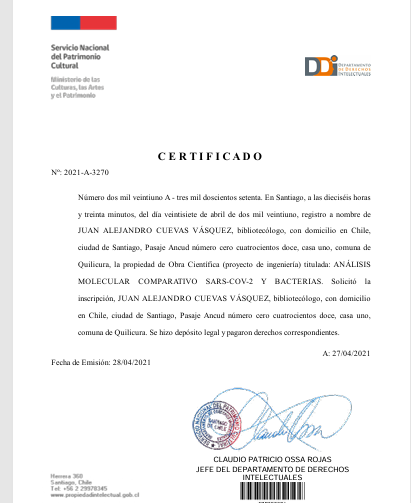
Algoritmo patentado